# Libraries and File

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('/content/DFORE339D2.csv', low_memory=False)

In [3]:
print('All rows: ', df.shape)
print('NULLS')
print(df.isnull().sum()[df.isnull().sum()>0])
df.dropna(inplace=True)
print('Nulls dropped ', df.shape)

All rows:  (104134, 42)
NULLS
location_id                     21
Location_Name                   87
Branch_Id                       17
Branch_Name                    139
state                           19
Daily_Max_Room_Vend_Hours        2
Total_Vend_Hours                 2
Overall_Utilization              2
Daily_Peak_Utilization           2
Full_Room_Util_Gross_Hours    1145
Full_Room_Util_Vend_PCT       1145
Full_Room_Util_Total_PCT      1145
AvgUtil_T                        1
AvgUtil_Sa                       1
nrpm                          3808
ContractExpirationDate         717
pay_cycle                      717
Days_To_ContractExpiration     717
dtype: int64
Nulls dropped  (99202, 42)


# Variables for Optimization

## Recency

In [4]:
df['Recency']= (df.TimeSinceFirstVend- df.TimeSinceLastTxn)/(df.TimeSinceFirstVend+1)


## Tenure Flag

In [5]:
df['Tenure_bkt']= df.Tenure_Flag.map({'New':0, 'Tenured':1})

In [6]:
def q90(x):
  return(x.quantile(0.9))
def q80(x):
  return(x.quantile(0.8))
def q70(x):
  return(x.quantile(0.7))
def q50(x):
  return(x.quantile(0.5))

## Quantiles

In [7]:
df2= df.groupby(['vendor', 'machine_type']).agg({'Avg_Install_Cap': 'median', 'Recency': [q90], 'Daily_Peak_Utilization': [q80]}).reset_index()
df2.columns=['vendor', 'machine_type', 'Avg_Install_Cap_Median', 'Recency_q90', 'Daily_Peak_Utilization_q80']
df3= df.groupby('vendor').agg({'nrpm': [q70]}).reset_index()
df3.columns=['vendor', 'nrpm_q70']

In [8]:
df1= df.merge(df2, on=['vendor', 'machine_type'])
df1= df1.merge(df3, on=['vendor'])

## Flags

In [9]:
df1['Recency_bkt']= np.where(df1.Recency < df1.Recency_q90, 1,0)
df1['McCount_bkt']= np.where(df1.Avg_Install_Cap > df1.Avg_Install_Cap_Median, 1,0)
df1['nrpm_bkt']= np.where(df1.nrpm < df1.nrpm_q70, 1, 0)

## Segments

In [10]:
df1['SegmentBeta1']= df1.Tenure_bkt*1000+ df1.Recency_bkt*100+ df1.McCount_bkt*10+ df1.nrpm_bkt
df1['SegmentBeta2']= df1.Tenure_bkt*(df1.Recency_bkt+ df1.nrpm_bkt+ df1.McCount_bkt)

In [11]:
df1['EligibleBeta1']= np.where(df1.SegmentBeta1==1111,'Haircut', 'Excused')
df1['EligibleBeta2']= np.where(df1.SegmentBeta2>=2,'Haircut', 'Excused')

# Optimization 

In [12]:
df1['Daily_Peak_Utilization_q80_ratio']= np.where(df1.Daily_Peak_Utilization/ df1.Daily_Peak_Utilization_q80> 1, 1,df1.Daily_Peak_Utilization/ df1.Daily_Peak_Utilization_q80)

## Constraint Ratio

In [13]:
for b in ['Beta1', 'Beta2']:
  mult= []
  c= 'Eligible'+b
  for index, row in df1.iterrows():
    if row[c]== 'Haircut':
      mult.append(max(0.75, row['Daily_Peak_Utilization_q80_ratio']))
    else:
      mult.append(1)
  df1['mult'+b]= mult

In [14]:
df1['RecoBeta1']= np.ceil(df1.Avg_Install_Cap*df1.multBeta1)
df1['RecoBeta2']= np.ceil(df1.Avg_Install_Cap*df1.multBeta2)

## Projected Utilization

In [15]:
df1['UtilMultBeta1']= df1.Avg_Install_Cap.divide(df1.RecoBeta1)
df1['UtilMultBeta2']= df1.Avg_Install_Cap.divide(df1.RecoBeta2)

In [16]:
df1['ProjectedUtilBeta1']= df1.Overall_Utilization*df1.UtilMultBeta1
df1['ProjectedUtilBeta2']= df1.Overall_Utilization*df1.UtilMultBeta2

## Vsualization Categories

In [17]:
# pd.concat([df1.Overall_Utilization, df1.ProjectedUtilBeta2, df1.ProjectedUtilBeta1], axis=0).describe(percentiles=[.25,.75,.95])

In [18]:
cuts= [-.98,2.33,4.03,6.19,10.38,100]
labs=['>=0- 2.33%', '>=2.33- 4.03%', '>=4.03- 6.19%', '>=6.19- 10.38%', '>=10.38%']

In [19]:
df1['ProjectedUtilBeta2_bkt']= pd.cut(df1.ProjectedUtilBeta2, cuts, labels=labs)
df1['ProjectedUtilBeta1_bkt']= pd.cut(df1.ProjectedUtilBeta1, cuts, labels=labs)
df1['OverallUtil_bkt']= pd.cut(df1.Overall_Utilization, cuts, labels=labs)

In [20]:
# pd.concat([df1.Avg_Install_Cap, df1.RecoBeta1, df1.RecoBeta2], axis=0).describe(percentiles=[.25,.75,.95])

In [21]:
cuts= [0,1,2,4,8,100]
labs= ['1 Unit', 'Two Units', '>2-4 Units', '>4-8 Units', '>8 Units']

In [22]:
df1['CurentMc_bkt']= pd.cut(df1.Avg_Install_Cap, cuts, labels= labs, right= True)
df1['RecoBeta1_bkt']= pd.cut(df1.RecoBeta1, cuts, labels= labs, right= True)
df1['RecoBeta2_bkt']= pd.cut(df1.RecoBeta2, cuts, labels= labs, right= True)

In [23]:
# pd.concat([df1.UtilMultBeta1, df1.UtilMultBeta2], axis=0).value_counts()

In [24]:
df1['UtilMultBeta1_bkt']= pd.cut(df1.UtilMultBeta1, [.99,1,1.3299, 1.4], labels=['No Change', 'Util Increase < 33%', 'Util Increase = 33%'])
df1['UtilMultBeta2_bkt']= pd.cut(df1.UtilMultBeta2, [.99,1,1.3299, 1.4], labels=['No Change', 'Util Increase < 33%', 'Util Increase = 33%'])

# Results

- Histograms current and projected utilization 3x2
- Hexbin CurrentMc_Bkt versus ReooBeta2_bkt- hexbin 3x2
- HeatMap OverallUtilbkt versus ProjectedUtilBkt_2- 3x2
- UtilMultBeta1 versus UtilMultBeta2- 3x2

In [25]:
df1.loc[df1.vendor=='DI','vendor']= 'CSCPay(DI)'

In [26]:
df1.machine_type.unique()

array(['DRYER', 'WASHER', 'STACKED'], dtype=object)

In [27]:
df1.Overall_Utilization.quantile(0.05)

0.57

### Histograms current and projected utilization 3x2

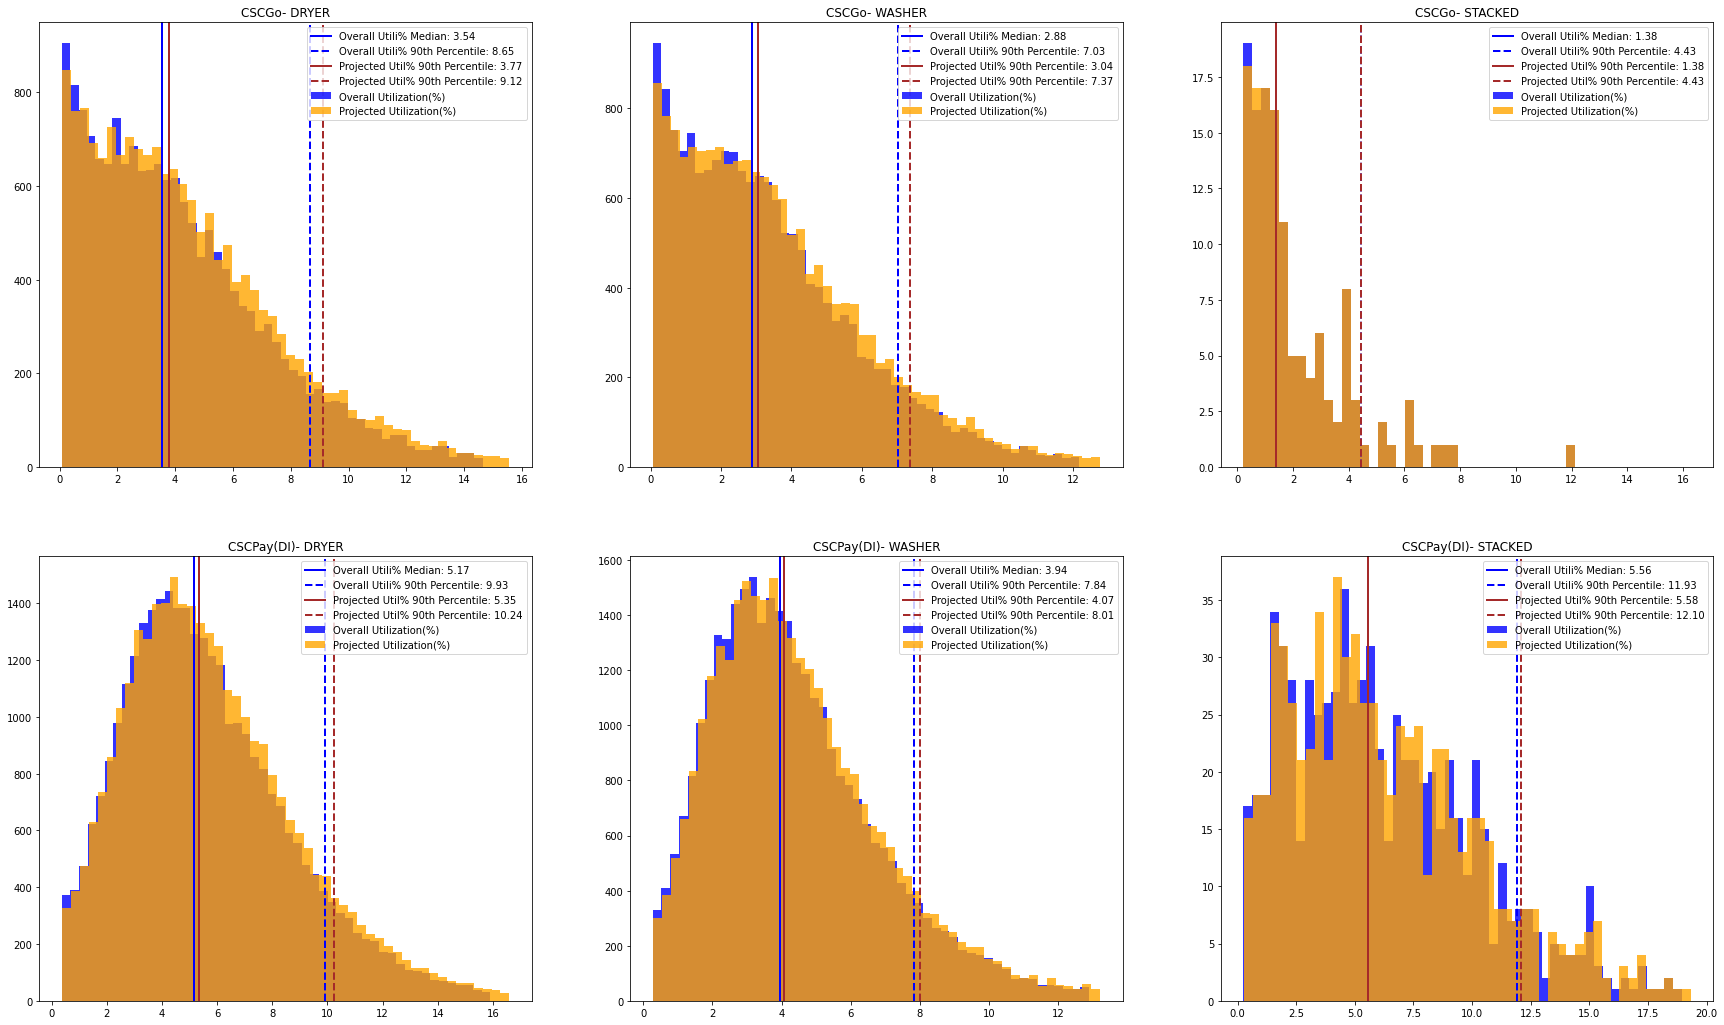

In [28]:
vendor=df1.vendor.unique()
machines= df1.machine_type.unique()
cols=[]
fig, ax = plt.subplots(len(vendor),len(machines),figsize=(30,18), sharey= False)
for i, v in enumerate(vendor):
  for k, m in enumerate(machines):
    sf= df1.loc[(df1['vendor']== v) & (df1['machine_type']== m)]
    ax[i,k].hist(sf.Overall_Utilization,color= 'blue', bins= 50, range=[sf.Overall_Utilization.quantile(0.01), sf.Overall_Utilization.quantile(0.99)], label= 'Overall Utilization(%)', alpha=.8)
    ax[i,k].axvline(sf.Overall_Utilization.median(), color='blue', linestyle='solid', linewidth=2, label= 'Overall Utili% Median: {:.2f}'.format(sf.Overall_Utilization.median()))
    ax[i,k].axvline(sf.Overall_Utilization.quantile(.9), color='blue', linestyle='dashed', linewidth=2, label= 'Overall Utili% 90th Percentile: {:.2f}'.format(sf.Overall_Utilization.quantile(.9)))
    ##
    ax[i,k].hist(sf.ProjectedUtilBeta2, color='orange', bins=50, range=[sf.ProjectedUtilBeta2.quantile(0.01), sf.ProjectedUtilBeta2.quantile(0.99)], label= 'Projected Utilization(%)', alpha=.8)
    ax[i,k].axvline(sf.ProjectedUtilBeta2.median(), color='brown', linestyle='solid', linewidth=2, label= 'Projected Util% 90th Percentile: {:.2f}'.format(sf.ProjectedUtilBeta2.median()))
    ax[i,k].axvline(sf.ProjectedUtilBeta2.quantile(.9), color='brown', linestyle='dashed', linewidth=2, label= 'Projected Util% 90th Percentile: {:.2f}'.format(sf.ProjectedUtilBeta2.quantile(.9)))
    ax[i,k].set_title(v+'- '+m)
    ax[i,k].legend()
plt.show()

### Heat Map CurrentMc_Bkt versus ReooBeta2_bkt- hexbin 3x2

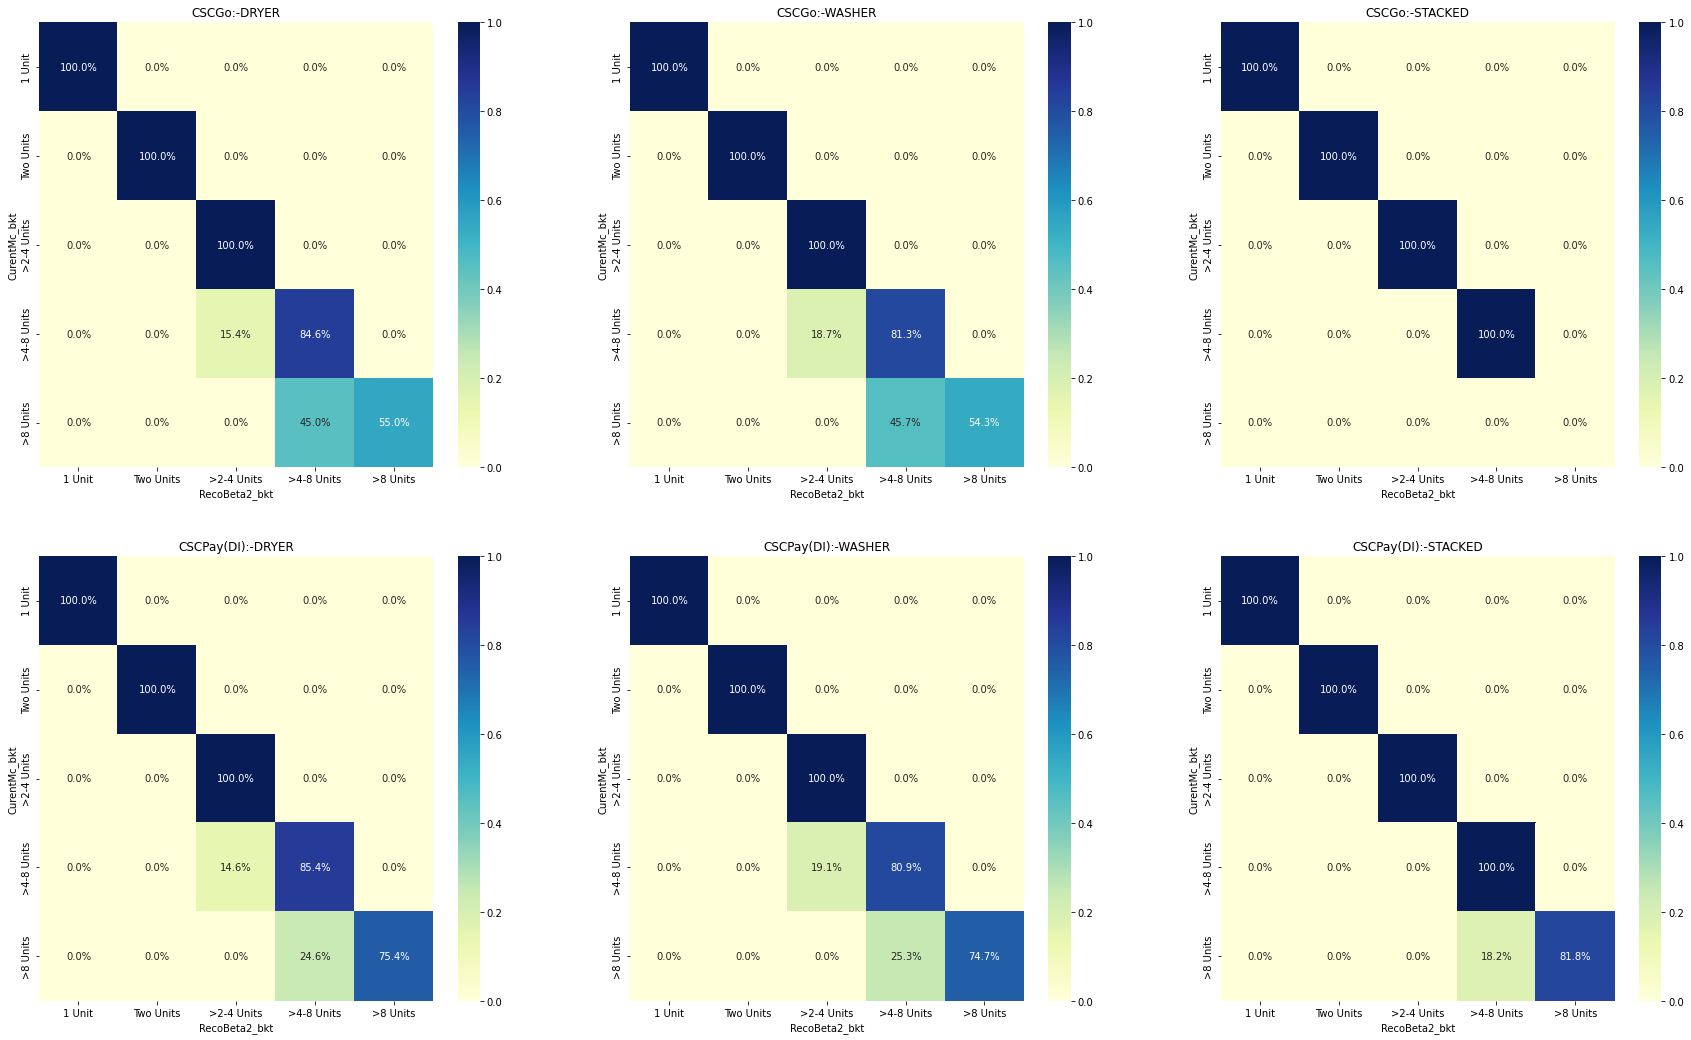

In [49]:
vendor=df1.vendor.unique()
machines= df1.machine_type.unique()
cols=[]
fig, ax = plt.subplots(len(vendor),len(machines),figsize=(30,18), sharey= False)
for i, v in enumerate(vendor):
  for k, m in enumerate(machines):
    sf= df1.loc[(df1['vendor']== v) & (df1['machine_type']== m)]
    # print(pd.crosstab(sf.CurentMc_bkt, sf.RecoBeta2_bkt, sf.room_id, aggfunc='nunique'))
    sns.heatmap(pd.crosstab(sf.CurentMc_bkt, sf.RecoBeta2_bkt, sf.room_id, aggfunc='nunique', normalize='index'), cmap="YlGnBu", ax=ax[i,k], annot= True, fmt=".1%")
    ax[i,k].set_title(v+':-'+m)
plt.show()

### HeatMap OverallUtilbkt versus ProjectedUtilBkt_2- 3x2

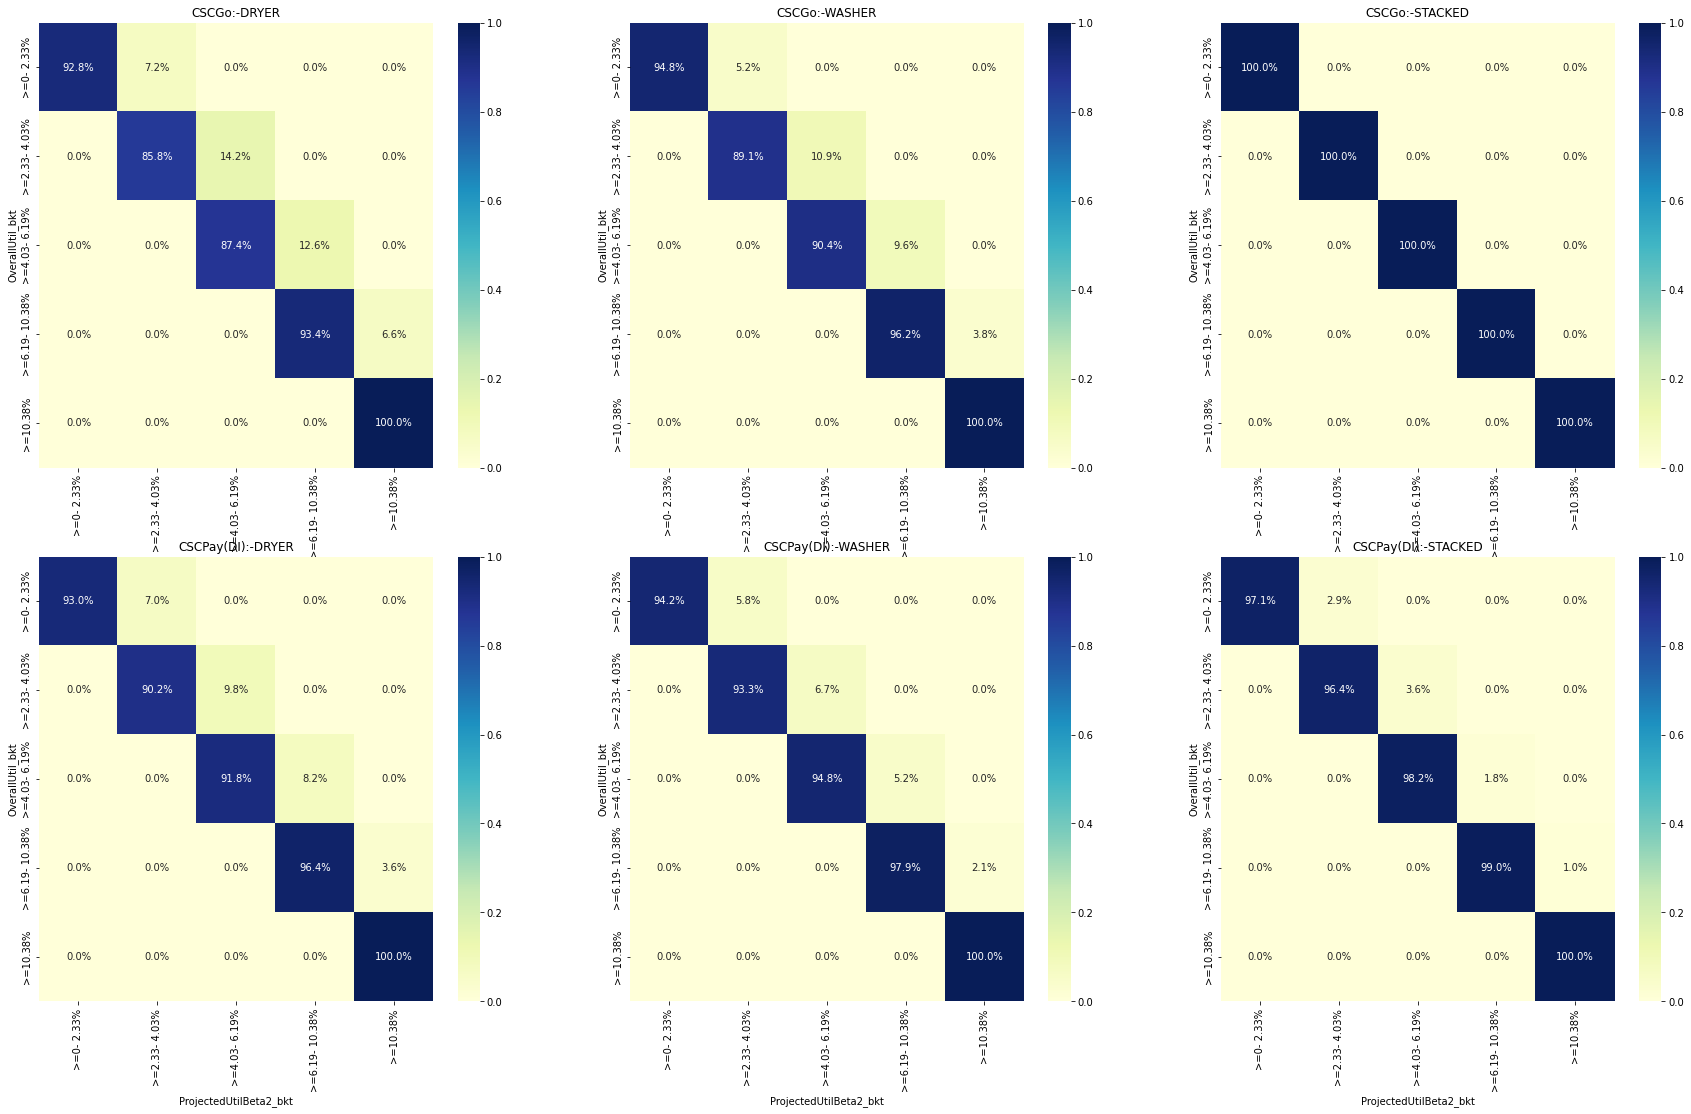

In [50]:
vendor=df1.vendor.unique()
machines= df1.machine_type.unique()
cols=[]
fig, ax = plt.subplots(len(vendor),len(machines),figsize=(30,18), sharey= False)
for i, v in enumerate(vendor):
  for k, m in enumerate(machines):
    sf= df1.loc[(df1['vendor']== v) & (df1['machine_type']== m)]
    # print(pd.crosstab(sf.CurentMc_bkt, sf.RecoBeta2_bkt, sf.room_id, aggfunc='nunique'))
    sns.heatmap(pd.crosstab(sf.OverallUtil_bkt, sf.ProjectedUtilBeta2_bkt, sf.room_id, aggfunc='nunique', normalize='index'), cmap="YlGnBu", ax=ax[i,k], annot= True, fmt=".1%")
    ax[i,k].set_title(v+':-'+m)
plt.show()

### Utilization Multiplier Buckets- Beta1 versus Beta 2

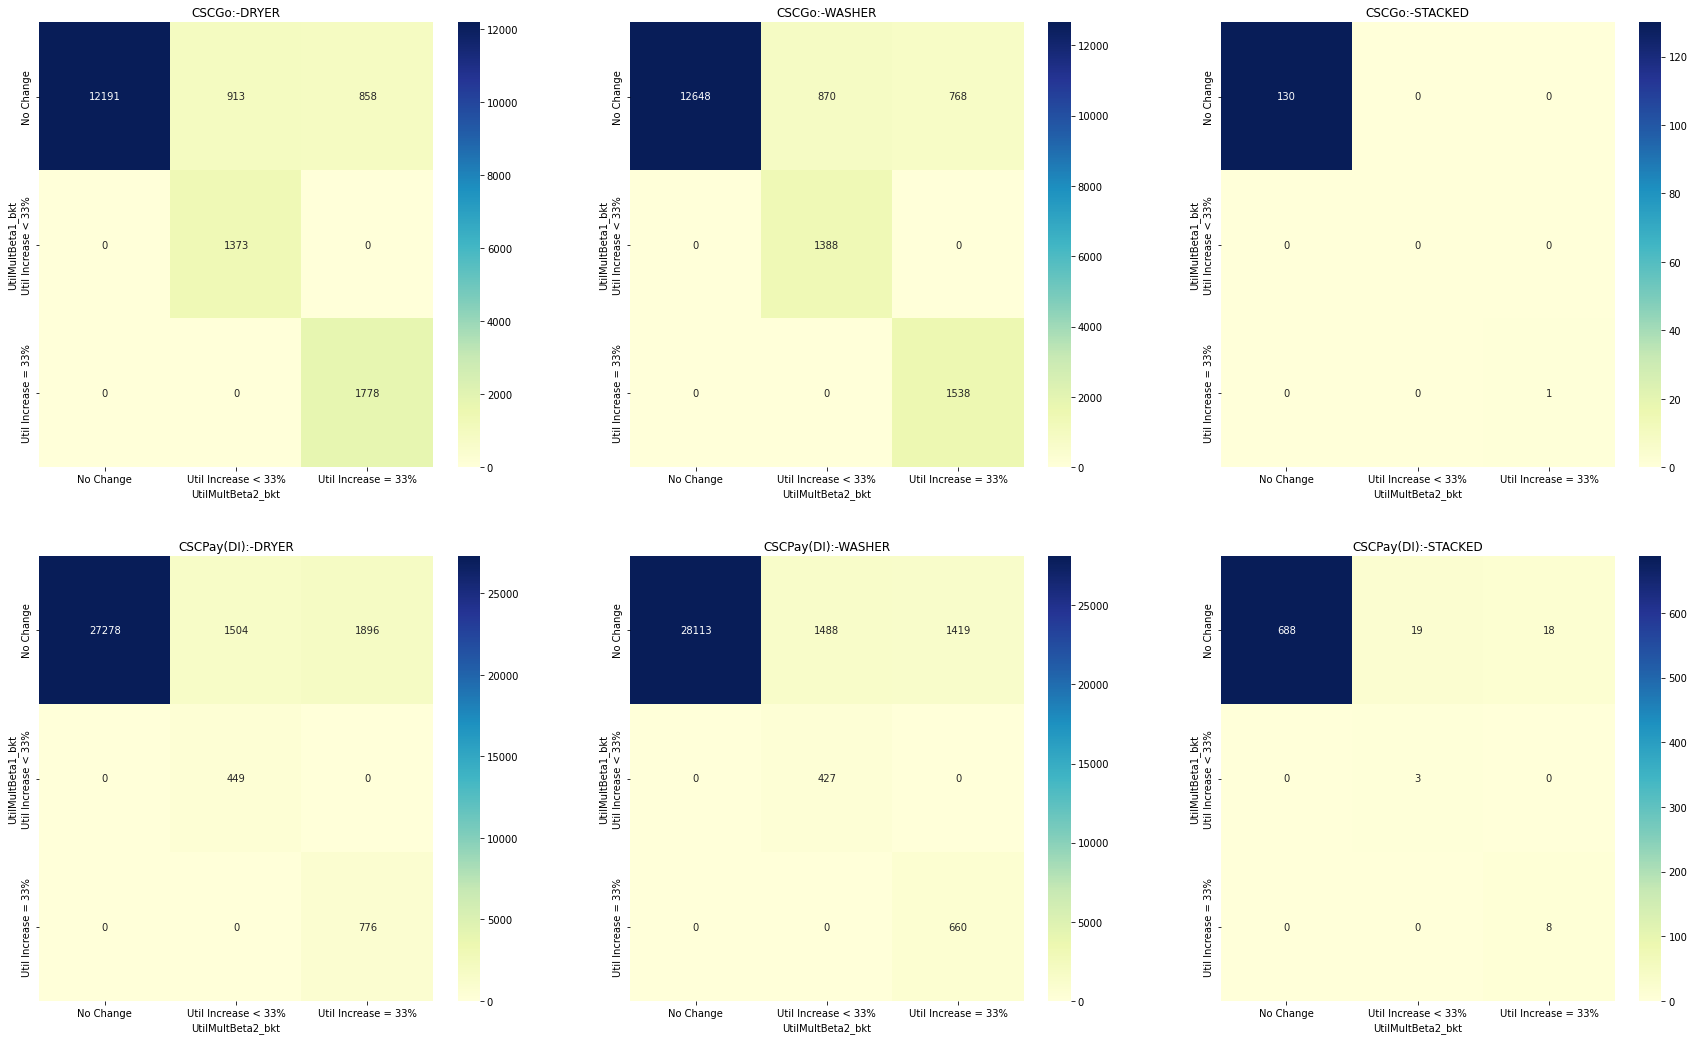

In [51]:
vendor=df1.vendor.unique()
machines= df1.machine_type.unique()
cols=[]
fig, ax = plt.subplots(len(vendor),len(machines),figsize=(30,18), sharey= False)
for i, v in enumerate(vendor):
  for k, m in enumerate(machines):
    sf= df1.loc[(df1['vendor']== v) & (df1['machine_type']== m)]
    # print(pd.crosstab(sf.CurentMc_bkt, sf.RecoBeta2_bkt, sf.room_id, aggfunc='nunique'))
    sns.heatmap(pd.crosstab(sf.UtilMultBeta1_bkt, sf.UtilMultBeta2_bkt, sf.room_id, aggfunc='nunique'), cmap="YlGnBu", ax=ax[i,k], annot= True, fmt='.0f')
    ax[i,k].set_title(v+':-'+m)
plt.show()

### Deltas

In [52]:
df21= df1.groupby(['vendor', 'machine_type'])['Avg_Install_Cap', 'RecoBeta2'].sum().reset_index()
df21['delta']=df21.Avg_Install_Cap- df21.RecoBeta2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [53]:
df21

,vendor,machine_type,Avg_Install_Cap,RecoBeta2,delta
0,CSCGo,DRYER,55944,49611.0,6333.0
1,CSCGo,STACKED,168,166.0,2.0
2,CSCGo,WASHER,55095,49271.0,5824.0
3,CSCPay(DI),DRYER,89438,83268.0,6170.0
4,CSCPay(DI),STACKED,1427,1344.0,83.0
5,CSCPay(DI),WASHER,87428,82046.0,5382.0


In [33]:
df22= df1.groupby(['vendor', 'machine_type'])['Avg_Install_Cap', 'RecoBeta1'].sum().reset_index()
df22['delta']=df22.Avg_Install_Cap- df22.RecoBeta1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [34]:
df22

,vendor,machine_type,Avg_Install_Cap,RecoBeta1,delta
0,CSCGo,DRYER,55944,51913.0,4031.0
1,CSCGo,STACKED,168,166.0,2.0
2,CSCGo,WASHER,55095,51393.0,3702.0
3,CSCPay(DI),DRYER,89438,87931.0,1507.0
4,CSCPay(DI),STACKED,1427,1411.0,16.0
5,CSCPay(DI),WASHER,87428,86100.0,1328.0


# Test

In [35]:
print('Beta 1 Utilization Error:', sum(df1.Overall_Utilization > df1.ProjectedUtilBeta1))
print('Beta 2 Utilization Error:', sum(df1.Overall_Utilization > df1.ProjectedUtilBeta2))
print('Beta 1 Machine Count Issue: ', sum(df1.RecoBeta1 > df1.Avg_Install_Cap))
print('Beta 2 Machine Count Issue: ', sum(df1.RecoBeta2 > df1.Avg_Install_Cap))

Beta 1 Utilization Error: 0
Beta 2 Utilization Error: 0
Beta 1 Machine Count Issue:  0
Beta 2 Machine Count Issue:  0


In [ ]:
df1.to_csv('RoomRightSizingBeta203142022.csv')

In [ ]:
df1.columns

Index(['Reporting_level', 'vendor', 'as400id', 'location_id', 'Location_Name',
       'Branch_Id', 'Branch_Name', 'state', 'room_id', 'machine_type',
       'TimeSinceFirstVend', 'TimeSinceLastTxn', 'Tenure_Flag',
       'Avg_Install_Cap', 'Room_Open_Hours', 'Daily_Max_Room_Vend_Hours',
       'Base_Vends', 'Base_Vend_Amount', 'Top_Up_Vends', 'Top_Up_Vend_Amount',
       'Total_Vend_Hours', 'Total_Hours_Open', 'Overall_Utilization',
       'Max_Daily_Vends', 'Daily_Peak_Utilization',
       'Full_Room_Util_Gross_Hours', 'Full_Room_Util_Vend_PCT',
       'Full_Room_Util_Total_PCT', 'Avg_Daily_Vends', 'VDPM', 'Vend_Price',
       'AvgUtil_M', 'AvgUtil_T', 'AvgUtil_W', 'AvgUtil_Th', 'AvgUtil_F',
       'AvgUtil_Sa', 'AvgUtil_Su', 'nrpm', 'ContractExpirationDate',
       'pay_cycle', 'Days_To_ContractExpiration', 'Recency', 'Tenure_bkt',
       'Avg_Install_Cap_Median', 'Recency_q90', 'Daily_Peak_Utilization_q80',
       'nrpm_q70', 'Recency_bkt', 'McCount_bkt', 'nrpm_bkt', 'SegmentBeta1',

In [ ]:
df1.columns

Index(['Reporting_level', 'vendor', 'as400id', 'location_id', 'Location_Name',
       'Branch_Id', 'Branch_Name', 'state', 'room_id', 'machine_type',
       'TimeSinceFirstVend', 'TimeSinceLastTxn', 'Tenure_Flag',
       'Avg_Install_Cap', 'Room_Open_Hours', 'Daily_Max_Room_Vend_Hours',
       'Base_Vends', 'Base_Vend_Amount', 'Top_Up_Vends', 'Top_Up_Vend_Amount',
       'Total_Vend_Hours', 'Total_Hours_Open', 'Overall_Utilization',
       'Max_Daily_Vends', 'Daily_Peak_Utilization',
       'Full_Room_Util_Gross_Hours', 'Full_Room_Util_Vend_PCT',
       'Full_Room_Util_Total_PCT', 'Avg_Daily_Vends', 'VDPM', 'Vend_Price',
       'AvgUtil_M', 'AvgUtil_T', 'AvgUtil_W', 'AvgUtil_Th', 'AvgUtil_F',
       'AvgUtil_Sa', 'AvgUtil_Su', 'nrpm', 'ContractExpirationDate',
       'pay_cycle', 'Days_To_ContractExpiration', 'Recency', 'Tenure_bkt',
       'Avg_Install_Cap_Median', 'Recency_q90', 'Daily_Peak_Utilization_q80',
       'nrpm_q70', 'Recency_bkt', 'McCount_bkt', 'nrpm_bkt', 'SegmentBeta1',

# Scrap

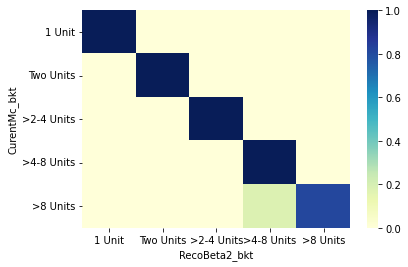

In [ ]:
sns.heatmap(pd.crosstab(sf.CurentMc_bkt, sf.RecoBeta2_bkt, sf.room_id, aggfunc='nunique', normalize='index'), cmap="YlGnBu")

In [ ]:
df1.UtilMultBeta2.describe()

count    99202.000000
mean         1.051484
std          0.111767
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.333333
Name: UtilMultBeta2, dtype: float64

In [ ]:
sum(df1.Overall_Utilization > df1.ProjectedUtilBeta2)

0

In [ ]:
df1.daily_peak

In [ ]:
sum(df1.Avg_Install_Cap > df1.ProjectedUtilBeta2)

30938

In [ ]:
df1.loc[df1.CurentMc_bkt== '1 Unit']['Avg_Install_Cap'].value_counts()

In [ ]:
df1.loc[df1.Avg_Install_Cap>=53].T

,59524,67964
Reporting_level,Room,Room
vendor,DI,DI
as400id,32771,32771
location_id,14522,14522
Location_Name,FRANKLIN PARK AT GREENBELT STATION,FRANKLIN PARK AT GREENBELT STATION
...,...,...
ProjectedUtilBeta1,6.98,5.51
ProjectedUtilBeta2,6.98,5.51
OverallUtil_bkt,>=6.19- 10.38%,>=4.03- 6.19%
ProjectedUtilBeta2_bkt,>=6.19- 10.38%,>=4.03- 6.19%


In [ ]:
df1.Avg_Install_Cap.dtypes

dtype('int64')

In [ ]:
df1[['multBeta1', 'multBeta2']].describe(percentiles=[.25,.75])

,multBeta1,multBeta2
count,99202.000000,99202.000000
mean,0.968642,0.883601
std,0.082065,0.119601
min,0.750000,0.750000
25%,1.000000,0.750000
50%,1.000000,0.943880
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
df.columns

Index(['Reporting_level', 'vendor', 'as400id', 'location_id', 'Location_Name',
       'Branch_Id', 'Branch_Name', 'state', 'room_id', 'machine_type',
       'TimeSinceFirstVend', 'TimeSinceLastTxn', 'Tenure_Flag',
       'Avg_Install_Cap', 'Room_Open_Hours', 'Daily_Max_Room_Vend_Hours',
       'Base_Vends', 'Base_Vend_Amount', 'Top_Up_Vends', 'Top_Up_Vend_Amount',
       'Total_Vend_Hours', 'Total_Hours_Open', 'Overall_Utilization',
       'Max_Daily_Vends', 'Daily_Peak_Utilization',
       'Full_Room_Util_Gross_Hours', 'Full_Room_Util_Vend_PCT',
       'Full_Room_Util_Total_PCT', 'Avg_Daily_Vends', 'VDPM', 'Vend_Price',
       'AvgUtil_M', 'AvgUtil_T', 'AvgUtil_W', 'AvgUtil_Th', 'AvgUtil_F',
       'AvgUtil_Sa', 'AvgUtil_Su', 'nrpm', 'ContractExpirationDate',
       'pay_cycle', 'Days_To_ContractExpiration', 'Recency'],
      dtype='object')

In [ ]:
df[['Avg_Install_Cap','Recency', 'Daily_Peak_Utilization', 'nrpm']].describe(percentiles=[.7,.8, .9])

,Avg_Install_Cap,Recency,Daily_Peak_Utilization,nrpm
count,99202.000000,99202.000000,99202.000000,99202.000000
mean,2.918288,0.936916,21.162766,38.315741
std,2.576219,0.162002,11.069767,26.210576
min,1.000000,0.005525,0.555554,-360.920000
50%,2.000000,0.983333,19.120369,35.910000
70%,3.000000,0.983425,25.000000,45.260000
80%,4.000000,0.983425,29.047619,51.320000
90%,6.000000,0.988950,35.595236,62.339000
max,54.000000,0.994475,100.000000,802.510000
